MIT-BIH Arrhythmia Database - Complete Preprocessing Pipeline
==============================================================
This script performs efficient preprocessing and creates stratified train-test splits.

Key Features:
- Signal cleaning (filtering, normalization)
- Beat segmentation
- Stratified splitting to handle class imbalance
- Ready-to-use datasets for model training



In [2]:
!pip install wfdb

In [3]:
import wfdb
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import pickle
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive successfully mounted to /content/drive")

Mounted at /content/drive
Google Drive successfully mounted to /content/drive


In [15]:
# DATA_PATH = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/'
DATA_PATH = './mit-bih-arrhythmia-database-1.0.0/'

In [16]:
OUTPUT_DIR = './processed_data/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [18]:
# MIT-BIH record IDs
RECORD_IDS = ['100', '101', '102', '103', '104', '105', '106', '107', '108',
              '109', '111', '112', '113', '114', '115', '116', '117', '118',
              '119', '121', '122', '123', '124', '200', '201', '202', '203',
              '205', '207', '208', '209', '210', '212', '213', '214', '215',
              '217', '219', '220', '221', '222', '223', '228', '230', '231',
              '232', '233', '234']

In [19]:
# Beat type mapping to 5 AAMI classes
BEAT_MAPPING = {
    'N': 'N',  # Normal
    'L': 'N',  # Left bundle branch block
    'R': 'N',  # Right bundle branch block
    'e': 'N',  # Atrial escape
    'j': 'N',  # Nodal escape
    'A': 'S',  # Supraventricular - Atrial premature
    'a': 'S',  # Supraventricular - Aberrated atrial premature
    'J': 'S',  # Supraventricular - Nodal premature
    'S': 'S',  # Supraventricular - Supraventricular premature
    'V': 'V',  # Ventricular - Premature
    'E': 'V',  # Ventricular - Escape
    'F': 'F',  # Fusion
    '/': 'Q',  # Paced
    'f': 'F',  # Fusion of paced and normal
    'Q': 'Q',  # Unclassifiable
}

In [20]:

# Preprocessing parameters
SAMPLING_RATE = 360  # Hz
WINDOW_SIZE = 180    # Samples before and after R-peak (0.5 seconds each side)
LOWCUT = 0.5         # High-pass filter cutoff (Hz) - removes baseline wander
HIGHCUT = 50.0       # Low-pass filter cutoff (Hz) - removes high-freq noise
NOTCH_FREQ = 60.0    # Powerline interference frequency (Hz)


In [21]:
# Train-test split parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

print("=" * 80)
print("MIT-BIH PREPROCESSING PIPELINE")
print("=" * 80)
print(f"\nConfiguration:")
print(f"  Data Path: {DATA_PATH}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Total Records: {len(RECORD_IDS)}")
print(f"  Window Size: {WINDOW_SIZE * 2} samples ({WINDOW_SIZE * 2 / SAMPLING_RATE:.2f} seconds)")
print(f"  Filters: HP={LOWCUT}Hz, LP={HIGHCUT}Hz, Notch={NOTCH_FREQ}Hz")
print(f"  Test Size: {TEST_SIZE * 100}%")


MIT-BIH PREPROCESSING PIPELINE

Configuration:
  Data Path: ./mit-bih-arrhythmia-database-1.0.0/
  Output Directory: ./processed_data/
  Total Records: 48
  Window Size: 360 samples (1.00 seconds)
  Filters: HP=0.5Hz, LP=50.0Hz, Notch=60.0Hz
  Test Size: 20.0%


1: SIGNAL FILTERING FUNCTIONS

In [22]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Applying Butterworth bandpass filter"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data, axis=0)
    return filtered_data

def notch_filter(data, freq, fs, quality=30):
    """Applying notch filter to remove powerline interference"""
    nyquist = 0.5 * fs
    freq_normalized = freq / nyquist
    b, a = signal.iirnotch(freq_normalized, quality)
    filtered_data = signal.filtfilt(b, a, data, axis=0)
    return filtered_data

    Complete signal preprocessing pipeline:
    1. Bandpass filter (0.5-50 Hz)
    2. Notch filter (60 Hz)
    3. Z-score normalization
    

In [23]:
def preprocess_signal(raw_signal, fs=SAMPLING_RATE):

    # bandpass filter
    filtered = butter_bandpass_filter(raw_signal, LOWCUT, HIGHCUT, fs)

    # notch filter
    filtered = notch_filter(filtered, NOTCH_FREQ, fs)

    # Z-score normalization (per signal)
    mean = np.mean(filtered, axis=0)
    std = np.std(filtered, axis=0)
    normalized = (filtered - mean) / (std + 1e-8)  # Epsilon to avoid division by zero

    return normalized

2: BEAT EXTRACTION

In [24]:
def extract_beats_from_record(record_id, window_before=WINDOW_SIZE, window_after=WINDOW_SIZE):
    """
    Extract and preprocess beats from a single record
    Returns: beats (array), labels (list), record_id (list)
    """
    try:
        # Load record and annotations
        record = wfdb.rdrecord(DATA_PATH + record_id)
        annotation = wfdb.rdann(DATA_PATH + record_id, 'atr')

        # Preprocess signal
        preprocessed_signal = preprocess_signal(record.p_signal, record.fs)

        beats = []
        labels = []
        record_ids = []

        # Extract beats around R-peaks
        for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
            # Skip non-beat annotations
            if symbol not in BEAT_MAPPING:
                continue

            # Check if beat is within valid range
            start_idx = sample - window_before
            end_idx = sample + window_after

            if start_idx >= 0 and end_idx < len(preprocessed_signal):
                # Extract beat segment (use first channel - MLII)
                beat = preprocessed_signal[start_idx:end_idx, 0]

                # Map to AAMI class
                label = BEAT_MAPPING[symbol]

                beats.append(beat)
                labels.append(label)
                record_ids.append(record_id)

        return np.array(beats), labels, record_ids

    except Exception as e:
        print(f" Error processing record {record_id}: {e}")
        return np.array([]), [], []


3: PROCESSING ALL RECORDS

In [25]:
print(f"\n{'=' * 80}")
print("STEP 1: EXTRACTING AND PREPROCESSING BEATS")
print("=" * 80)

all_beats = []
all_labels = []
all_record_ids = []

print("\n Processing all records...")
for record_id in tqdm(RECORD_IDS, desc="Processing records"):
    beats, labels, record_ids = extract_beats_from_record(record_id)

    if len(beats) > 0:
        all_beats.append(beats)
        all_labels.extend(labels)
        all_record_ids.extend(record_ids)

# Concatenate all beats
X = np.concatenate(all_beats, axis=0)
y = np.array(all_labels)
record_ids_array = np.array(all_record_ids)

print(f"\n Extraction Complete!")
print(f"   Total beats extracted: {len(X):,}")
print(f"   Beat shape: {X.shape}")
print(f"   Unique classes: {np.unique(y)}")

# Display class distribution
print(f"\n Class Distribution (Before Split):")
class_counts = Counter(y)
for class_name in ['N', 'S', 'V', 'F', 'Q']:
    count = class_counts.get(class_name, 0)
    percentage = (count / len(y)) * 100
    print(f"   {class_name}: {count:6,} beats ({percentage:5.2f}%)")


STEP 1: EXTRACTING AND PREPROCESSING BEATS

 Processing all records...


Processing records: 100%|██████████| 48/48 [00:10<00:00,  4.44it/s]


 Extraction Complete!
   Total beats extracted: 109,438
   Beat shape: (109438, 360)
   Unique classes: ['F' 'N' 'Q' 'S' 'V']

 Class Distribution (Before Split):
   N: 90,582 beats (82.77%)
   S:  2,781 beats ( 2.54%)
   V:  7,235 beats ( 6.61%)
   F:  1,784 beats ( 1.63%)
   Q:  7,056 beats ( 6.45%)


4: STRATIFIED TRAIN-TEST SPLIT

In [26]:
print(f"\n{'=' * 80}")
print("STEP 2: CREATING STRATIFIED TRAIN-TEST SPLIT")
print("=" * 80)

# Calculation of dominant class for each patient
patient_labels = {}
for record_id in np.unique(record_ids_array):
    patient_mask = record_ids_array == record_id
    patient_y = y[patient_mask]
    # Getting the most common class for this patient
    dominant_class = Counter(patient_y).most_common(1)[0][0]
    patient_labels[record_id] = dominant_class

unique_records = np.array(list(patient_labels.keys()))
patient_dominant_classes = np.array([patient_labels[r] for r in unique_records])

print(f"\n Splitting strategy: Stratified inter-patient split")
print(f"   Total patients (records): {len(unique_records)}")


# Checking if we have enough samples per class for stratified split
class_counts_patients = Counter(patient_dominant_classes)
print(f"\n   Patient distribution by dominant class:")
for cls in sorted(class_counts_patients.keys()):
    print(f"      {cls}: {class_counts_patients[cls]} patients")

# stratified split at patient level, try part
try:
    train_records, test_records = train_test_split(
        unique_records,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=patient_dominant_classes,
        shuffle=True
    )
    split_method = "Patient-level stratified"
    print(f"\n Using patient-level stratified split")

except ValueError as e:
    print(f"\n  Patient-level stratification not possible: {e}")
    print(f"   Falling back to beat-level stratified split")

    # Direct stratified split on all beats
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y,  # Stratify by beat labels
        shuffle=True
    )
    split_method = "Beat-level stratified"
    print(f" Using beat-level stratified split")

    # Skip the mask-based splitting below
    train_records = None
    test_records = None

# If patient-level stratification succeeded, create masks
if train_records is not None:
    print(f"   Train patients: {len(train_records)}")
    print(f"   Test patients: {len(test_records)}")

    # Create train and test masks based on record IDs
    train_mask = np.isin(record_ids_array, train_records)
    test_mask = np.isin(record_ids_array, test_records)

    # Split data
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]

print(f"\n Split Complete ({split_method})")
print(f"   Training samples: {len(X_train):,}")
print(f"   Testing samples: {len(X_test):,}")
print(f"   Split ratio: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% / {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")

# Displaying class distribution in train and test
print(f"\n Class Distribution in Training Set:")
train_class_counts = Counter(y_train)
for class_name in ['N', 'S', 'V', 'F', 'Q']:
    count = train_class_counts.get(class_name, 0)
    percentage = (count / len(y_train)) * 100
    print(f"   {class_name}: {count:6,} beats ({percentage:5.2f}%)")

print(f"\n Class Distribution in Testing Set:")
test_class_counts = Counter(y_test)
for class_name in ['N', 'S', 'V', 'F', 'Q']:
    count = test_class_counts.get(class_name, 0)
    percentage = (count / len(y_test)) * 100
    print(f"   {class_name}: {count:6,} beats ({percentage:5.2f}%)")

# Verifying stratification - compare train/test distributions
print(f"\n Stratification Verification:")
print(f"   {'Class':<8} {'Train %':<10} {'Test %':<10} {'Difference':<12}")
print(f"   {'-'*8} {'-'*10} {'-'*10} {'-'*12}")
for class_name in ['N', 'S', 'V', 'F', 'Q']:
    train_pct = (train_class_counts.get(class_name, 0) / len(y_train)) * 100
    test_pct = (test_class_counts.get(class_name, 0) / len(y_test)) * 100
    diff = abs(train_pct - test_pct)
    print(f"   {class_name:<8} {train_pct:>6.2f}%    {test_pct:>6.2f}%    {diff:>6.2f}%")

# Ensuring all classes are present in both sets
train_classes = set(y_train)
test_classes = set(y_test)
missing_in_test = train_classes - test_classes
missing_in_train = test_classes - train_classes

if missing_in_test or missing_in_train:
    print(f"\n  WARNING: Class mismatch detected!")
    if missing_in_test:
        print(f"   Classes missing in test set: {missing_in_test}")
    if missing_in_train:
        print(f"   Classes missing in train set: {missing_in_train}")
else:
    print(f"\n All classes present in both train and test sets")



STEP 2: CREATING STRATIFIED TRAIN-TEST SPLIT

 Splitting strategy: Stratified inter-patient split
   Total patients (records): 48

   Patient distribution by dominant class:
      N: 43 patients
      Q: 4 patients
      S: 1 patients

  Patient-level stratification not possible: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
   Falling back to beat-level stratified split
 Using beat-level stratified split

 Split Complete (Beat-level stratified)
   Training samples: 87,550
   Testing samples: 21,888
   Split ratio: 80.0% / 20.0%

 Class Distribution in Training Set:
   N: 72,465 beats (82.77%)
   S:  2,225 beats ( 2.54%)
   V:  5,788 beats ( 6.61%)
   F:  1,427 beats ( 1.63%)
   Q:  5,645 beats ( 6.45%)

 Class Distribution in Testing Set:
   N: 18,117 beats (82.77%)
   S:    556 beats ( 2.54%)
   V:  1,447 beats ( 6.61%)
   F:    357 beats ( 1.63%)
   Q:  1,411 beats ( 6.45%)

 Stratification Veri

5: ENCODE LABELS

In [27]:
print(f"\n{'=' * 80}")
print("STEP 3: ENCODING LABELS")
print("=" * 80)

# Encode string labels to integers; fitting only on traing data
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\n Labels Encoded!")
print(f"   Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"      {class_name} -> {i}")



STEP 3: ENCODING LABELS

 Labels Encoded!
   Class mapping:
      F -> 0
      N -> 1
      Q -> 2
      S -> 3
      V -> 4


6: ADDITIONAL NORMALIZATION

In [28]:
print(f"\n{'=' * 80}")
print("STEP 4: FINAL NORMALIZATION")
print("=" * 80)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Normalization Completed")
print(f"   Train set - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"   Test set - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")



STEP 4: FINAL NORMALIZATION

 Normalization Completed
   Train set - Mean: 0.000000, Std: 1.000000
   Test set - Mean: 0.001551, Std: 1.004005


7: SAVE PROCESSED DATA

In [29]:
print(f"\n{'=' * 80}")
print("STEP 5: SAVING PROCESSED DATA")
print("=" * 80)

# Saveing as numpy arrays (efficient for large datasets)
np.save(os.path.join(OUTPUT_DIR, 'X_train.npy'), X_train_scaled)
np.save(os.path.join(OUTPUT_DIR, 'X_test.npy'), X_test_scaled)
np.save(os.path.join(OUTPUT_DIR, 'y_train.npy'), y_train_encoded)
np.save(os.path.join(OUTPUT_DIR, 'y_test.npy'), y_test_encoded)

# Saving unscaled versions as well
np.save(os.path.join(OUTPUT_DIR, 'X_train_unscaled.npy'), X_train)
np.save(os.path.join(OUTPUT_DIR, 'X_test_unscaled.npy'), X_test)

# Saving metadata
metadata = {
    'label_encoder': label_encoder,
    'scaler': scaler,
    'train_records': train_records if train_records is not None else 'beat-level-split',
    'test_records': test_records if test_records is not None else 'beat-level-split',
    'split_method': split_method,
    'class_names': label_encoder.classes_,
    'train_class_distribution': train_class_counts,
    'test_class_distribution': test_class_counts,
    'window_size': WINDOW_SIZE * 2,
    'sampling_rate': SAMPLING_RATE,
    'num_train_samples': len(X_train),
    'num_test_samples': len(X_test),
    'stratified': True,
}

with open(os.path.join(OUTPUT_DIR, 'metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)

print(f"\n All data saved to: {OUTPUT_DIR}")
print(f"\n Files created:")
print(f"   1. X_train.npy - Training features (scaled)")
print(f"   2. X_test.npy - Testing features (scaled)")
print(f"   3. y_train.npy - Training labels (encoded)")
print(f"   4. y_test.npy - Testing labels (encoded)")
print(f"   5. X_train_unscaled.npy - Training features (unscaled)")
print(f"   6. X_test_unscaled.npy - Testing features (unscaled)")
print(f"   7. metadata.pkl - Label encoder, scaler, and other info")



STEP 5: SAVING PROCESSED DATA

 All data saved to: ./processed_data/

 Files created:
   1. X_train.npy - Training features (scaled)
   2. X_test.npy - Testing features (scaled)
   3. y_train.npy - Training labels (encoded)
   4. y_test.npy - Testing labels (encoded)
   5. X_train_unscaled.npy - Training features (unscaled)
   6. X_test_unscaled.npy - Testing features (unscaled)
   7. metadata.pkl - Label encoder, scaler, and other info



MIT-BIH Arrhythmia Classification with Attention Architecture
====================================================================
Implements the architecture from your diagram:
- ResNet Encoder for feature extraction
- Guided Attention (Clinical + Temporal)
- Dual output: Classification + Reconstruction



In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [32]:
# CONFIGURATION
CONFIG = {
    'data_dir': './processed_data/',
    'model_dir': './models/',
    'batch_size': 128,
    'epochs': 10,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patience': 15,  # Early stopping patience
    'reconstruction_weight': 0.3,  # Weight for reconstruction loss
    'classification_weight': 1.0,  # Weight for classification loss
}

os.makedirs(CONFIG['model_dir'], exist_ok=True)


In [33]:
# DATASET CLASS

class ECGDataset(Dataset):
    """Dataset class for ECG signals"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension [N, 1, 360]
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [34]:
# MODEL COMPONENTS
class ResidualBlock(nn.Module):
    """Residual block for ResNet encoder"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7,
                               stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7,
                               stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [35]:
class ResNetEncoder(nn.Module):
    """ResNet-based encoder for feature extraction"""
    def __init__(self, num_blocks=[2, 2, 2, 2]):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        return out

In [36]:

class ClinicalAttention(nn.Module):
    """Clinical attention focusing on morphological features"""
    def __init__(self, in_channels):
        super(ClinicalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels // 4, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        att_weights = self.attention(x)
        return x * att_weights, att_weights


In [37]:

class TemporalAttention(nn.Module):
    """Temporal attention focusing on time-series patterns"""
    def __init__(self, in_channels):
        super(TemporalAttention, self).__init__()
        self.query = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, length = x.size()

        proj_query = self.query(x).view(batch_size, -1, length).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, length)

        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value(x).view(batch_size, -1, length)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, length)

        out = self.gamma * out + x
        return out, attention

In [38]:

class GuidedAttention(nn.Module):
    """Combines clinical and temporal attention"""
    def __init__(self, in_channels):
        super(GuidedAttention, self).__init__()
        self.clinical_attention = ClinicalAttention(in_channels)
        self.temporal_attention = TemporalAttention(in_channels)

    def forward(self, x):
        # Clinical attention
        clinical_out, clinical_weights = self.clinical_attention(x)

        # Temporal attention
        temporal_out, temporal_weights = self.temporal_attention(clinical_out)

        return temporal_out, clinical_weights, temporal_weights


In [39]:

class ECGReconstructor(nn.Module):
    """Decoder for ECG signal reconstruction"""
    def __init__(self, in_channels=512, target_length=360):
        super(ECGReconstructor, self).__init__()
        self.target_length = target_length

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        out = self.decoder(x)

        if out.size(2) != self.target_length:
            out = F.interpolate(out, size=self.target_length, mode='linear', align_corners=False)
        return out


In [40]:
class MultiAttentionECGModel(nn.Module):
    """
    Complete multi-attention model for ECG classification
    Following the architecture diagram
    """
    def __init__(self, num_classes=5, input_length=360):
        super(MultiAttentionECGModel, self).__init__()

        # Encoder
        self.encoder = ResNetEncoder()

        # Guided Attention
        self.guided_attention = GuidedAttention(in_channels=512)

        # Classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # Reconstructor
        self.reconstructor = ECGReconstructor(in_channels=512, target_length=input_length)

    def forward(self, x):
        # Encode
        features = self.encoder(x)

        # Guided attention
        attended_features, clinical_att, temporal_att = self.guided_attention(features)

        # Classification branch
        pooled = self.global_pool(attended_features).squeeze(-1)
        class_output = self.classifier(pooled)

        # Reconstruction branch
        reconstructed = self.reconstructor(attended_features)

        return class_output, reconstructed, clinical_att, temporal_att



TRAINING FUNCTION

In [ ]:

def train_epoch(model, train_loader, criterion_class, criterion_recon,
                optimizer, device, class_weights):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        class_output, reconstructed, _, _ = model(inputs)

        # Calculate losses
        class_loss = criterion_class(class_output, targets)
        recon_loss = criterion_recon(reconstructed, inputs)

        # Combined loss
        loss = (CONFIG['classification_weight'] * class_loss +
                CONFIG['reconstruction_weight'] * recon_loss)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = class_output.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion_class, criterion_recon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            class_output, reconstructed, _, _ = model(inputs)

            # Calculate losses
            class_loss = criterion_class(class_output, targets)
            recon_loss = criterion_recon(reconstructed, inputs)
            loss = (CONFIG['classification_weight'] * class_loss +
                    CONFIG['reconstruction_weight'] * recon_loss)

            # Statistics
            total_loss += loss.item()
            _, predicted = class_output.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    # ADD THIS: Calculate comprehensive metrics

    from sklearn.metrics import precision_score, recall_score, f1_score
    
    accuracy = 100. * correct / total
    
    # Calculate weighted metrics (important for imbalanced data)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
    # Return all metrics
    metrics = {
        'loss': total_loss / len(val_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_preds,
        'targets': all_targets
    }
    
    return metrics  # Changed from returning individual values
    
    # return total_loss / len(val_loader), 100. * correct / total, all_preds, all_targets


MAIN TRAINING SCRIPT

MULTI-ATTENTION ECG CLASSIFICATION MODEL

Loading preprocessed data...
Data loaded successfully
  Train samples: 87,550
  Test samples: 21,888
  Classes: ['F' 'N' 'Q' 'S' 'V']
  Input shape: 360

Class weights for imbalanced data:
  F: 12.2705
  N: 0.2416
  Q: 3.1019
  S: 7.8697
  V: 3.0252

Building model...
 Model created
   Total parameters: 10,049,639
   Trainable parameters: 10,049,639

Starting training for 10 epochs...
   Batch size: 128
   Learning rate: 0.001
   Early stopping patience: 15

Epoch 1/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.15it/s, loss=0.2988, acc=92.82%]



Epoch Summary:
  Train Loss: 0.6042 | Train Acc: 78.51%
  Val Loss:   0.3200 | Val Acc:   92.82%
   Val Precision: 0.9624
   Val Recall:    0.9282
   Val F1-Score:  0.9401
   Learning Rate: 0.001000
  Best model saved! (Val Loss: 0.3200)

Epoch 2/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.77it/s, loss=0.7271, acc=78.92%]



Epoch Summary:
  Train Loss: 0.2963 | Train Acc: 90.58%
  Val Loss:   0.3664 | Val Acc:   78.92%
   Val Precision: 0.9342
   Val Recall:    0.7892
   Val F1-Score:  0.8346
   Learning Rate: 0.001000
  No improvement. Patience: 1/15

Epoch 3/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 55.87it/s, loss=0.2197, acc=85.69%]



Epoch Summary:
  Train Loss: 0.2383 | Train Acc: 91.30%
  Val Loss:   0.3825 | Val Acc:   85.69%
   Val Precision: 0.9437
   Val Recall:    0.8569
   Val F1-Score:  0.8844
   Learning Rate: 0.001000
  No improvement. Patience: 2/15

Epoch 4/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.02it/s, loss=0.1595, acc=91.74%]



Epoch Summary:
  Train Loss: 0.2004 | Train Acc: 92.92%
  Val Loss:   0.2114 | Val Acc:   91.74%
   Val Precision: 0.9681
   Val Recall:    0.9174
   Val F1-Score:  0.9362
   Learning Rate: 0.001000
  Best model saved! (Val Loss: 0.2114)

Epoch 5/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.55it/s, loss=0.3568, acc=91.26%]



Epoch Summary:
  Train Loss: 0.1739 | Train Acc: 93.78%
  Val Loss:   0.2304 | Val Acc:   91.26%
   Val Precision: 0.9579
   Val Recall:    0.9126
   Val F1-Score:  0.9275
   Learning Rate: 0.001000
  No improvement. Patience: 1/15

Epoch 6/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 55.91it/s, loss=0.1872, acc=96.27%]



Epoch Summary:
  Train Loss: 0.1571 | Train Acc: 94.76%
  Val Loss:   0.1915 | Val Acc:   96.27%
   Val Precision: 0.9763
   Val Recall:    0.9627
   Val F1-Score:  0.9673
   Learning Rate: 0.001000
  Best model saved! (Val Loss: 0.1915)

Epoch 7/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.86it/s, loss=0.1354, acc=92.23%]



Epoch Summary:
  Train Loss: 0.1589 | Train Acc: 94.26%
  Val Loss:   0.1601 | Val Acc:   92.23%
   Val Precision: 0.9644
   Val Recall:    0.9223
   Val F1-Score:  0.9362
   Learning Rate: 0.001000
  Best model saved! (Val Loss: 0.1601)

Epoch 8/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.79it/s, loss=0.0817, acc=94.59%]



Epoch Summary:
  Train Loss: 0.1432 | Train Acc: 94.63%
  Val Loss:   0.1641 | Val Acc:   94.59%
   Val Precision: 0.9654
   Val Recall:    0.9459
   Val F1-Score:  0.9519
   Learning Rate: 0.001000
  No improvement. Patience: 1/15

Epoch 9/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.75it/s, loss=0.1536, acc=95.99%]



Epoch Summary:
  Train Loss: 0.1364 | Train Acc: 95.26%
  Val Loss:   0.1217 | Val Acc:   95.99%
   Val Precision: 0.9749
   Val Recall:    0.9599
   Val F1-Score:  0.9647
   Learning Rate: 0.001000
  Best model saved! (Val Loss: 0.1217)

Epoch 10/10


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.77it/s, loss=0.1413, acc=93.54%]



Epoch Summary:
  Train Loss: 0.1183 | Train Acc: 96.03%
  Val Loss:   0.1618 | Val Acc:   93.54%
   Val Precision: 0.9702
   Val Recall:    0.9354
   Val F1-Score:  0.9476
   Learning Rate: 0.001000
  No improvement. Patience: 1/15

FINAL EVALUATION


Validation: 100%|██████████| 171/171 [00:03<00:00, 56.38it/s, loss=0.1536, acc=95.99%]



Best Model Performance:
  Accuracy:  95.99%
  Loss:      0.1217
  Precision: 0.9749 | Recall: 0.9599 | F1: 0.9647

Detailed Classification Report:
              precision    recall  f1-score   support

           F     0.4414    0.9496    0.6027       357
           N     0.9982    0.9573    0.9773     18117
           Q     0.9922    0.9887    0.9904      1411
           S     0.6476    0.9586    0.7730       556
           V     0.9241    0.9682    0.9457      1447

    accuracy                         0.9599     21888
   macro avg     0.8007    0.9645    0.8578     21888
weighted avg     0.9749    0.9599    0.9647     21888

Confusion matrix saved!
Training history saved!

TRAINING COMPLETED
All results saved to: ./models/


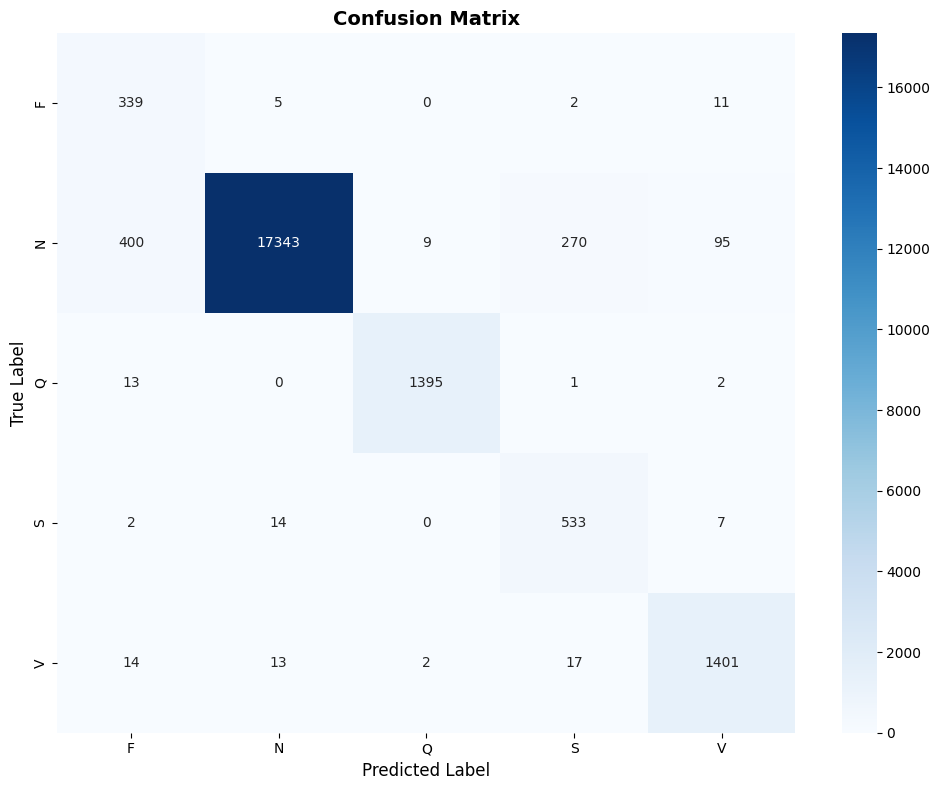

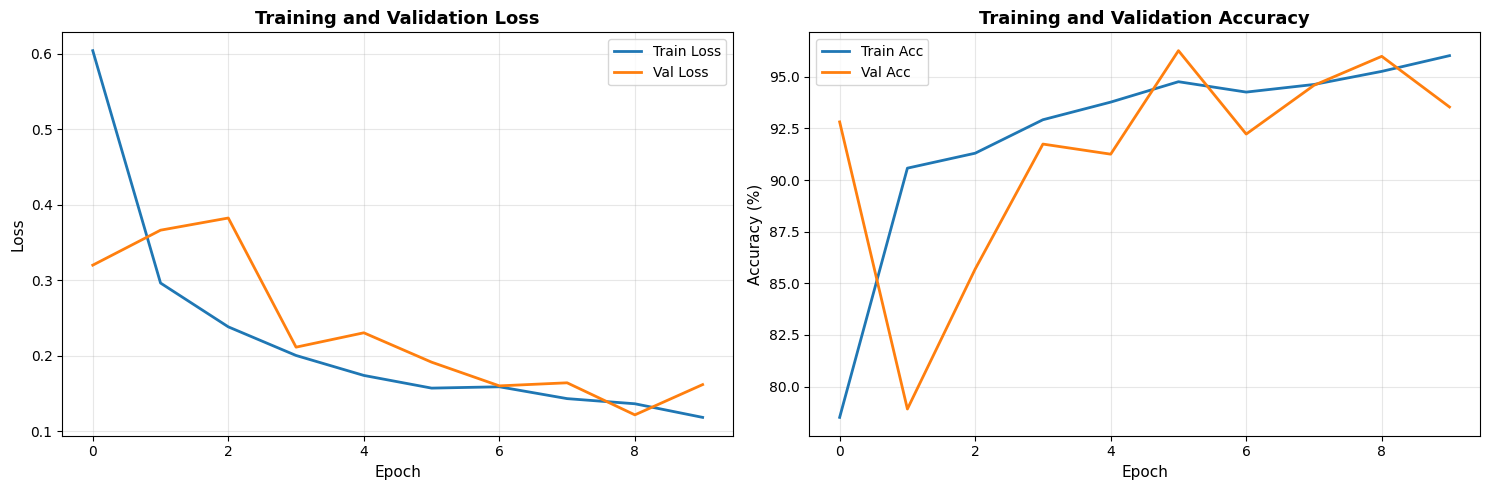

In [50]:
def main():
    print("=" * 80)
    print("MULTI-ATTENTION ECG CLASSIFICATION MODEL")
    print("=" * 80)

    # Load preprocessed data
    print("\nLoading preprocessed data...")
    X_train = np.load(os.path.join(CONFIG['data_dir'], 'X_train.npy'))
    X_test = np.load(os.path.join(CONFIG['data_dir'], 'X_test.npy'))
    y_train = np.load(os.path.join(CONFIG['data_dir'], 'y_train.npy'))
    y_test = np.load(os.path.join(CONFIG['data_dir'], 'y_test.npy'))

    with open(os.path.join(CONFIG['data_dir'], 'metadata.pkl'), 'rb') as f:
        metadata = pickle.load(f)

    num_classes = len(metadata['class_names'])
    class_names = metadata['class_names']

    print(f"Data loaded successfully")
    print(f"  Train samples: {len(X_train):,}")
    print(f"  Test samples: {len(X_test):,}")
    print(f"  Classes: {class_names}")
    print(f"  Input shape: {X_train.shape[1]}")

    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    test_dataset = ECGDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                              shuffle=True, num_workers=4, pin_memory=True)
   
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                             shuffle=False, num_workers=4, pin_memory=True)

    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(y_train),
                                         y=y_train)
    
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    print("\nClass weights for imbalanced data:")
    for name, weight in zip(class_names, class_weights):
        print(f"  {name}: {weight:.4f}")

    # Initialize model
    print("\nBuilding model...")
    model = MultiAttentionECGModel(num_classes=num_classes,
                                   input_length=X_train.shape[1]).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" Model created")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")


    # Loss functions and optimizer
    criterion_class = nn.CrossEntropyLoss(weight=class_weights)
    criterion_recon = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=CONFIG['learning_rate'],
                                 weight_decay=CONFIG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    # Training loop
    print(f"\nStarting training for {CONFIG['epochs']} epochs...")
    print(f"   Batch size: {CONFIG['batch_size']}")
    print(f"   Learning rate: {CONFIG['learning_rate']}")
    print(f"   Early stopping patience: {CONFIG['patience']}")

    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': [],
               'val_precision': [], 'val_recall': [], 'val_f1': []}

    for epoch in range(CONFIG['epochs']):
        print(f"\n{'=' * 80}")
        print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
        print(f"{'=' * 80}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion_class,
                                            criterion_recon, optimizer, device, class_weights)

        # Validate
        val_metrics = validate(model, test_loader, criterion_class, criterion_recon, device)

        #Extract metrics
        val_loss = val_metrics['loss']
        val_acc = val_metrics['accuracy']
        val_precision = val_metrics['precision']
        val_recall = val_metrics['recall']
        val_f1 = val_metrics['f1_score']

        # Update scheduler
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Track additional metrics in history
        if 'val_precision' not in history:
            history['val_precision'] = []
            history['val_recall'] = []
            history['val_f1'] = []
        
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print summary
        print(f"\nEpoch Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"   Val Precision: {val_precision:.4f}")
        print(f"   Val Recall:    {val_recall:.4f}")
        print(f"   Val F1-Score:  {val_f1:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
                'class_names': class_names,
                'config': CONFIG
            }, os.path.join(CONFIG['model_dir'], 'best_model.pth'))
            print(f"  Best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{CONFIG['patience']}")

        # Early stopping
        if patience_counter >= CONFIG['patience']:
            print(f"\n Early stopping triggered after {epoch + 1} epochs.")
            break

    # Final Evaluation
    print(f"\n{'=' * 80}")
    print("FINAL EVALUATION")
    print(f"{'=' * 80}")

    checkpoint = torch.load(os.path.join(CONFIG['model_dir'], 'best_model.pth'), weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    final_metrics = validate(model, test_loader, criterion_class, criterion_recon, device)
    
    print(f"\nBest Model Performance:")
    print(f"  Accuracy:  {final_metrics['accuracy']:.2f}%")
    print(f"  Loss:      {final_metrics['loss']:.4f}")
    print(f"  Precision: {final_metrics['precision']:.4f} | Recall: {final_metrics['recall']:.4f} | F1: {final_metrics['f1_score']:.4f}")

    #Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(final_metrics['targets'], final_metrics['predictions'],
                                target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(final_metrics['targets'], final_metrics['predictions'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['model_dir'], 'confusion_matrix.png'), dpi=150)
    print("Confusion matrix saved!")

    # Training History plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    #Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['model_dir'], 'training_history.png'), dpi=150)
    print("Training history saved!")

    print(f"\n{'=' * 80}")
    print("TRAINING COMPLETED")
    print(f"{'=' * 80}")
    print(f"All results saved to: {CONFIG['model_dir']}")


if __name__ == '__main__':
    main()


Loaded best model from epoch 8


Validation: 100%|██████████| 171/171 [00:02<00:00, 59.10it/s, loss=0.7264, acc=72.88%]



OVERALL METRICS
Macro Average: Accuracy=0.7288, Precision=0.6364, Recall=0.6772, F1=0.5812
Weighted Average: Precision=0.9178, Recall=0.7288, F1=0.8044

PER-CLASS DETAILED METRICS
              precision    recall  f1-score   support

           F     0.0594    0.8319    0.1110       357
           N     0.9666    0.7396    0.8380     18117
           Q     0.6124    0.6215    0.6170      1411
           S     0.6072    0.3921    0.4765       556
           V     0.9362    0.8010    0.8633      1447

    accuracy                         0.7288     21888
   macro avg     0.6364    0.6772    0.5812     21888
weighted avg     0.9178    0.7288    0.8044     21888



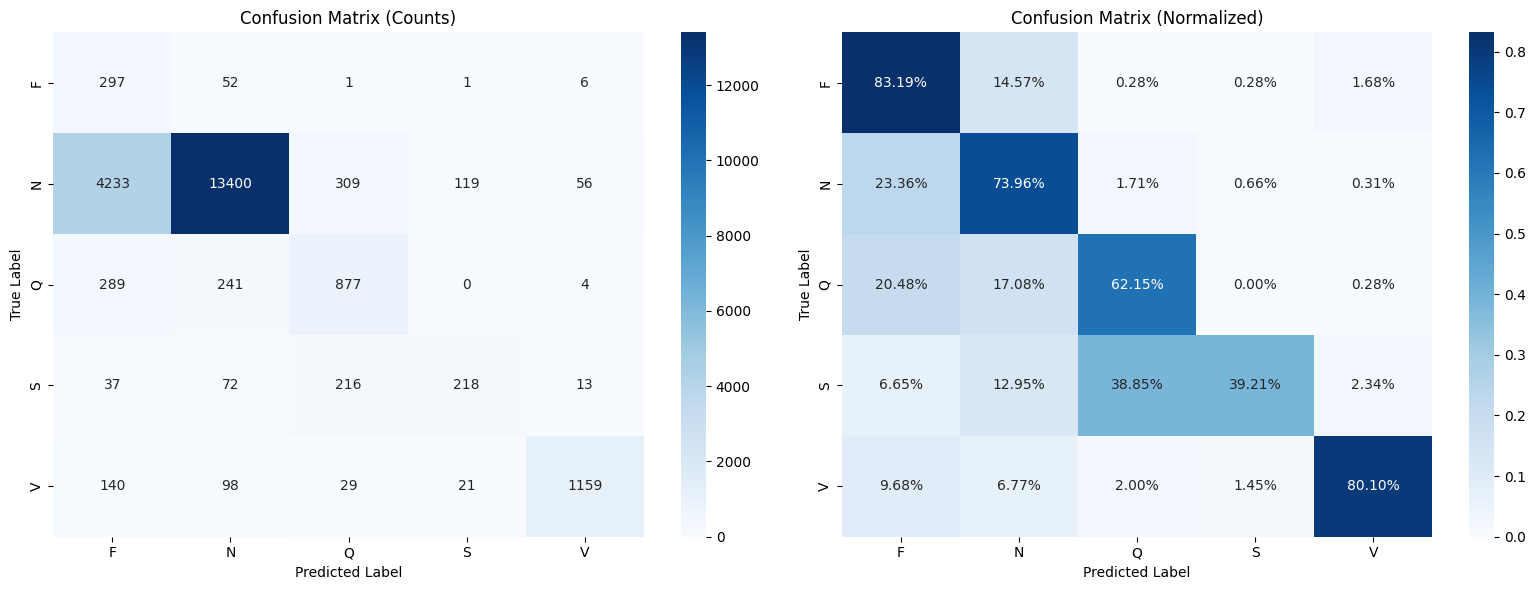

Confusion matrix saved!

PER-CLASS ACCURACY BREAKDOWN
Class          Correct   Total     Accuracy    Error Rate  
F              297       357       0.8319      0.1681      
N              13400     18117     0.7396      0.2604      
Q              877       1411      0.6215      0.3785      
S              218       556       0.3921      0.6079      
V              1159      1447      0.8010      0.1990      

Total misclassifications: 5937 / 21888 (27.12%)

Top 5 Confusion Pairs:
True Class     Predicted As   Count     % of True Class
N              F              4233      23.36%
N              Q              309       1.71%
Q              F              289       20.48%
Q              N              241       17.08%
S              Q              216       38.85%

EVALUATION COMPLETE!


In [57]:
# COMPREHENSIVE FINAL EVALUATION

# Load metadata to get class mapping
with open(os.path.join(CONFIG['data_dir'], 'metadata.pkl'), 'rb') as f:
    metadata = pickle.load(f)

class_names = metadata['class_names']
label_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Encode y_test if it's string labels
y_test_encoded = np.array([label_to_idx[y] for y in y_test])

# Load best model
checkpoint = torch.load(os.path.join(CONFIG['model_dir'], 'best_model.pth'), weights_only=False)
model = MultiAttentionECGModel(num_classes=len(class_names), input_length=X_test.shape[1]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Define loss functions for evaluation
class_weights = torch.ones(len(class_names)).to(device)  # If you want balanced weights, adjust here
criterion_class = nn.CrossEntropyLoss(weight=class_weights)
criterion_recon = nn.MSELoss()

# Create test loader
test_dataset = ECGDataset(X_test, y_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Get final predictions
final_metrics = validate(model, test_loader, criterion_class, criterion_recon, device)
y_true = np.array(final_metrics['targets'])
y_pred = np.array(final_metrics['predictions'])

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\nOVERALL METRICS")
print(f"Macro Average: Accuracy={accuracy:.4f}, Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")
print(f"Weighted Average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1={f1_weighted:.4f}")

# Per-class metrics
print("\nPER-CLASS DETAILED METRICS")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['model_dir'], 'final_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved!")

# Per-class accuracy breakdown
print("\nPER-CLASS ACCURACY BREAKDOWN")
print(f"{'Class':<15}{'Correct':<10}{'Total':<10}{'Accuracy':<12}{'Error Rate':<12}")
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    class_correct = np.sum((y_true == i) & (y_pred == i))
    class_total = np.sum(class_mask)
    class_acc = class_correct / class_total if class_total > 0 else 0
    error_rate = 1 - class_acc
    print(f"{class_name:<15}{class_correct:<10}{class_total:<10}{class_acc:<12.4f}{error_rate:<12.4f}")

# Misclassification analysis
misclassified_mask = y_true != y_pred
n_misclassified = np.sum(misclassified_mask)
print(f"\nTotal misclassifications: {n_misclassified} / {len(y_true)} ({n_misclassified/len(y_true)*100:.2f}%)")

# Top 5 confusion pairs
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            count = np.sum((y_true == i) & (y_pred == j))
            if count > 0:
                pct = count / np.sum(y_true == i) * 100
                confusion_pairs.append((class_names[i], class_names[j], count, pct))
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop 5 Confusion Pairs:")
print(f"{'True Class':<15}{'Predicted As':<15}{'Count':<10}{'% of True Class'}")
for true_cls, pred_cls, count, pct in confusion_pairs[:5]:
    print(f"{true_cls:<15}{pred_cls:<15}{count:<10}{pct:.2f}%")

print("\nEVALUATION COMPLETE!")